In [1]:
#from google.colab import drive
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython

import plotly.graph_objects as go
import plotly.express as px

from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

# Load Data

In [2]:
#drive.mount('/content/drive')

In [3]:
""" df=pd.read_csv('/content/drive/MyDrive/DataX_Team7/Team7_Bitcoin_Price_Prediction/Investment_Strategy/test-investment-strat.csv')
df.set_index('time', inplace=True, drop=True)
df.head() """


" df=pd.read_csv('/content/drive/MyDrive/DataX_Team7/Team7_Bitcoin_Price_Prediction/Investment_Strategy/test-investment-strat.csv')\ndf.set_index('time', inplace=True, drop=True)\ndf.head() "

In [4]:
df=pd.read_csv('../test-investment-strat.csv')

In [5]:
df.shape

(10080, 23)

In [6]:
df=df[['current_TFI_sum', 'bid_ask_spread_mean','volume', 'mid_price' ]] # mid_price not only next minute 
df.dropna(axis=0, inplace=True)
df.head() 

,current_TFI_sum,bid_ask_spread_mean,volume,mid_price
0,-4.890432,7.142457,10.994332,57231.165
1,-6.299339,10.022932,22.290937,57067.445
2,4.386762,9.277828,34.798676,56931.680
3,-4.687885,10.185243,32.778637,56884.895
4,-1.064082,8.051544,15.061907,56834.570


# Helper functions

In [7]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [8]:
train_df.shape

(7049, 4)

## Normalization

In [9]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

## Data Windowing

In [10]:
class WindowGenerator():
  def __init__(self
            , input_width
            , label_width, shift
            , train_df=train_df
            , val_df=val_df
            , test_df=test_df
            , label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

split window --> Given a list consecutive inputs, the split_window method will convert them to a window of inputs and a window of labels.


The initial window is all consecutive samples, this splits it into an (inputs, labels) pairs

In [11]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [12]:
def plot(self, model=None, plot_col='mid_price', max_subplots=5):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [min]')

WindowGenerator.plot = plot

In [13]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [14]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Windows definition

### Custom Window

In [15]:
custom_window= WindowGenerator(input_width=30, label_width=30, shift=5,
                     label_columns=['mid_price'])
custom_window

Total window size: 35
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34]
Label column name(s): ['mid_price']

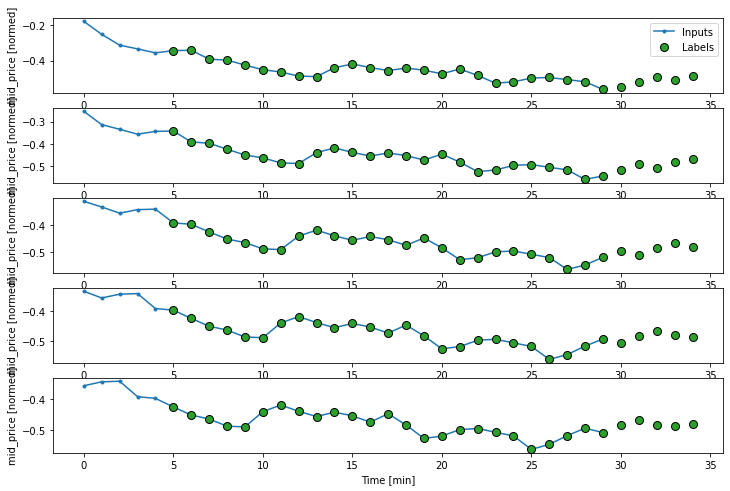

In [16]:
custom_window.plot()

# Wndow lstm 

In [36]:
custom_window_lstm= WindowGenerator(input_width=30, label_width=30, shift=30,
                     label_columns=['mid_price'])
custom_window_lstm

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]
Label column name(s): ['mid_price']

# Models

## Baseline

In [18]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [19]:
baseline = Baseline(label_index=column_indices['mid_price'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanSquaredError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(custom_window_lstm.val, verbose=1)
performance['Baseline'] = baseline.evaluate(custom_window_lstm.test, verbose=1)

9/9 [==============================] - 0s 1ms/step - loss: 0.0139 - mean_squared_error: 0.0139


In [20]:
performance

{'Baseline': [0.013874976895749569, 0.013874975964426994]}

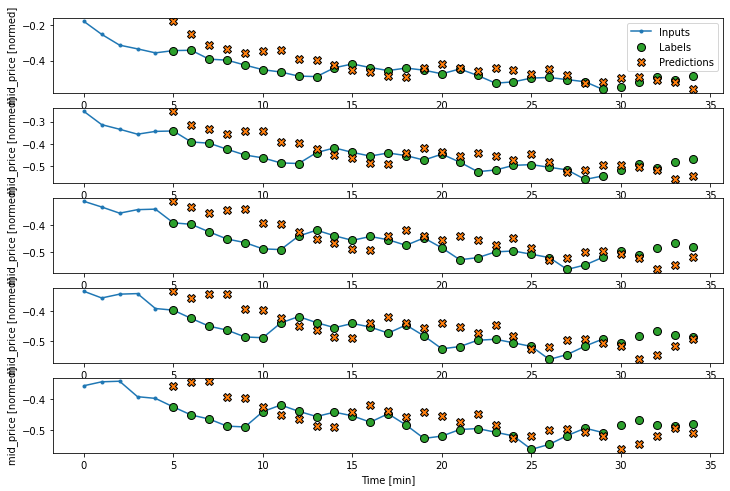

In [21]:
custom_window.plot(baseline)

## Linear

In [22]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [23]:
print('Input shape:', custom_window_lstm.example[0].shape)
print('Output shape:', linear(custom_window_lstm.example[0]).shape)

Input shape: (32, 720, 4)
Output shape: (32, 720, 1)


In [24]:
MAX_EPOCHS = 10

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),#MeanAbsoluteError
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [25]:
history = compile_and_fit(linear, custom_window_lstm)

val_performance['Linear'] = linear.evaluate(custom_window_lstm.val)
performance['Linear'] = linear.evaluate(custom_window_lstm.test, verbose=0)

Epoch 1/10
197/197 [==============================] - 1s 4ms/step - loss: 1.2902 - mean_squared_error: 1.2902 - val_loss: 0.1467 - val_mean_squared_error: 0.1467
Epoch 2/10
197/197 [==============================] - 0s 2ms/step - loss: 0.9274 - mean_squared_error: 0.9274 - val_loss: 0.1023 - val_mean_squared_error: 0.1023
Epoch 3/10
197/197 [==============================] - 0s 2ms/step - loss: 0.6430 - mean_squared_error: 0.6430 - val_loss: 0.0726 - val_mean_squared_error: 0.0726
Epoch 4/10
197/197 [==============================] - 0s 2ms/step - loss: 0.4351 - mean_squared_error: 0.4351 - val_loss: 0.0523 - val_mean_squared_error: 0.0523
Epoch 5/10
197/197 [==============================] - 0s 2ms/step - loss: 0.2870 - mean_squared_error: 0.2870 - val_loss: 0.0387 - val_mean_squared_error: 0.0387
Epoch 6/10
197/197 [==============================] - 0s 2ms/step - loss: 0.1854 - mean_squared_error: 0.1854 - val_loss: 0.0302 - val_mean_squared_error: 0.0302
Epoch 7/10
197/197 [========

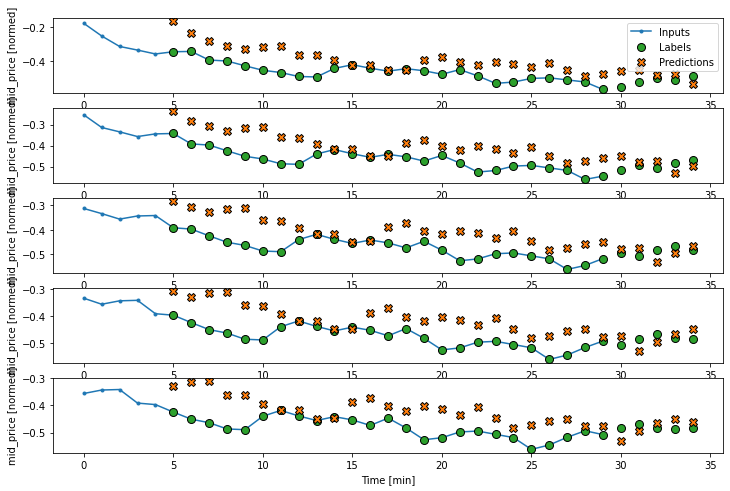

In [26]:
custom_window.plot(linear)

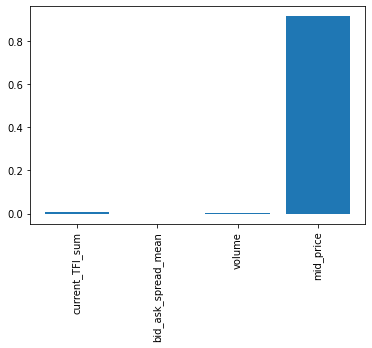

In [27]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [28]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, custom_window_lstm)

val_performance['Dense'] = dense.evaluate(custom_window_lstm.val)
performance['Dense'] = dense.evaluate(custom_window_lstm.test, verbose=0)

Epoch 1/10
197/197 [==============================] - 3s 11ms/step - loss: 0.1295 - mean_squared_error: 0.1295 - val_loss: 0.0369 - val_mean_squared_error: 0.0369
Epoch 2/10
197/197 [==============================] - 2s 11ms/step - loss: 0.0296 - mean_squared_error: 0.0296 - val_loss: 0.0375 - val_mean_squared_error: 0.0375
Epoch 3/10
197/197 [==============================] - 2s 11ms/step - loss: 0.0291 - mean_squared_error: 0.0291 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 4/10
197/197 [==============================] - 2s 11ms/step - loss: 0.0284 - mean_squared_error: 0.0284 - val_loss: 0.0355 - val_mean_squared_error: 0.0355
Epoch 5/10
197/197 [==============================] - 2s 12ms/step - loss: 0.0279 - mean_squared_error: 0.0279 - val_loss: 0.0347 - val_mean_squared_error: 0.0347
Epoch 6/10
197/197 [==============================] - 2s 11ms/step - loss: 0.0274 - mean_squared_error: 0.0274 - val_loss: 0.0350 - val_mean_squared_error: 0.0350
Epoch 7/10
40/40 [====

## RNN/ LSTM

In [29]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(30),
    #tf.keras.layers.Dropout(0.3),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [30]:
print('Input shape:', custom_window_lstm.example[0].shape)
print('Output shape:', lstm_model(custom_window_lstm.example[0]).shape)

Input shape: (32, 720, 4)
Output shape: (32, 1)


In [31]:
MAX_EPOCHS=10

lstm_history = compile_and_fit(lstm_model, custom_window_lstm)

#IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(custom_window_lstm.val)
performance['LSTM'] = lstm_model.evaluate(custom_window_lstm.test, verbose=0)

Epoch 1/10
197/197 [==============================] - 31s 151ms/step - loss: 0.1857 - mean_squared_error: 0.1857 - val_loss: 0.8275 - val_mean_squared_error: 0.8275
Epoch 2/10
197/197 [==============================] - 29s 145ms/step - loss: 0.7480 - mean_squared_error: 0.7480 - val_loss: 0.2835 - val_mean_squared_error: 0.2835
Epoch 3/10
197/197 [==============================] - 30s 151ms/step - loss: 0.4373 - mean_squared_error: 0.4373 - val_loss: 0.2762 - val_mean_squared_error: 0.2762
Epoch 4/10
197/197 [==============================] - 30s 150ms/step - loss: 0.4364 - mean_squared_error: 0.4364 - val_loss: 0.2746 - val_mean_squared_error: 0.2746
Epoch 5/10
197/197 [==============================] - 31s 158ms/step - loss: 0.4269 - mean_squared_error: 0.4269 - val_loss: 0.2810 - val_mean_squared_error: 0.2810
Epoch 6/10
40/40 [==============================] - 1s 31ms/step - loss: 0.2939 - mean_squared_error: 0.2939


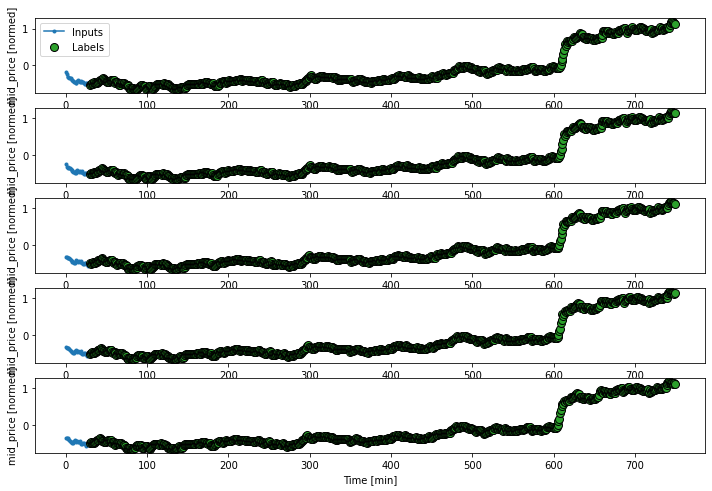

In [32]:
custom_window_lstm.plot()

In [33]:
val_performance

{'Baseline': [0.022730201482772827, 0.022730207070708275],
 'Linear': [0.021343840286135674, 0.021343844011425972],
 'Dense': [0.03519988805055618, 0.035199884325265884],
 'LSTM': [0.29392555356025696, 0.29392555356025696]}

In [34]:
#custom_window.plot(lstm_model)

# Model Comparison

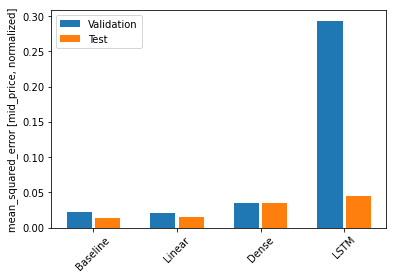

In [35]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_squared_error'
metric_index = lstm_model.metrics_names.index('mean_squared_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_squared_error [mid_price, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

# LSTM Tuning

## MAX_EPOCHS 

In [ ]:
def plot_learning(history,label,c,ax_loss,ax_acc):
  train_label = "train ({0})".format(label)
  val_label   = "validation ({0})".format(label)
  if 'loss' in history.history:
    ax_loss.plot(history.history['loss'],c=c,label=train_label)
  if 'val_loss' in history.history:
    ax_loss.plot(history.history['val_loss'],'--',c=c,label=val_label)
  if 'mean_squared_error' in history.history:
    ax_acc.plot(history.history['mean_squared_error'],c=c,label=train_label)
  if 'val_mean_squared_error' in history.history:
    ax_acc.plot(history.history['val_mean_squared_error'],'--',c=c,label=val_label)

  for ax in [ax_loss,ax_acc]:
    ax.legend()
    ax.grid('on')
    ax.set_xlabel("epoch")
  ax_loss.set_ylabel("Loss")
  ax_acc.set_ylabel("Accuracy")

In [448]:
pd.DataFrame(lstm_history.history)

,loss,mean_squared_error,val_loss,val_mean_squared_error
0,0.075954,0.075954,0.034741,0.034741
1,0.028449,0.028449,0.021674,0.021674
2,0.017371,0.017371,0.010314,0.010314
3,0.011307,0.011307,0.007415,0.007415
4,0.008220,0.008220,0.006083,0.006083
5,0.006604,0.006604,0.006021,0.006021
6,0.005971,0.005971,0.006182,0.006182
7,0.005786,0.005786,0.006081,0.006081


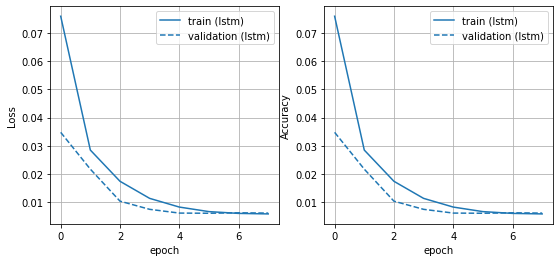

In [447]:
fig, AX = plt.subplots(nrows=1,ncols=2,figsize=(9,4))
plot_learning(lstm_history, 'lstm', 'C0', AX[0], AX[1])

In [ ]:
MAX_EPOCHS_grid

## LSTM units

In [524]:
MAX_EPOCHS=10
tr={}
v={}
te={}
units_grid=np.arange(10,100,10)
for units in units_grid: 
    lstm_model_test = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(units, return_sequences=True),
        #tf.keras.layers.Dropout(i, seed=0),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)
    ])

    history = compile_and_fit(lstm_model_test, custom_window)

    IPython.display.clear_output()
    tr[str(units)] = lstm_model_test.evaluate(custom_window.train)
    v[str(units)] = lstm_model_test.evaluate(custom_window.val)
    te[str(units)] = lstm_model_test.evaluate(custom_window.test, verbose=0)

62/62 [==============================] - 0s 4ms/step - loss: 0.0053 - mean_squared_error: 0.0053


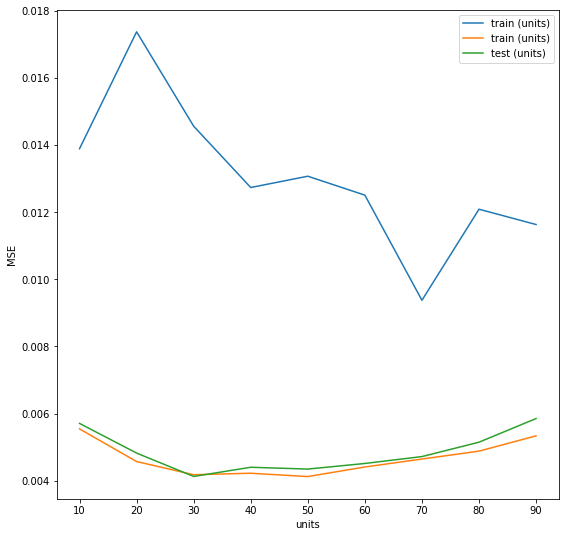

In [531]:
fig, AX = plt.subplots(nrows=1,ncols=1,figsize=(9,9))
label='units'

ax_train=AX
ax_val=AX
ax_test=AX

train_label = "train ({0})".format(label)
val_label = "val ({0})".format(label)
test_label = "test ({0})".format(label)

ax_train.plot(pd.DataFrame(tr).T[0],c='C0',label=train_label)
ax_val.plot(pd.DataFrame(v).T[0],c='C1',label=train_label)
ax_test.plot(pd.DataFrame(te).T[0],c='C2',label=test_label)

for ax in [ax_train, ax_val, ax_test]:
    ax.legend()
    ax.set_xlabel("units")
    ax.set_ylabel("MSE")

#ax_val.set_ylabel("Validation MSE")
#ax_test.set_ylabel("Test MSE")



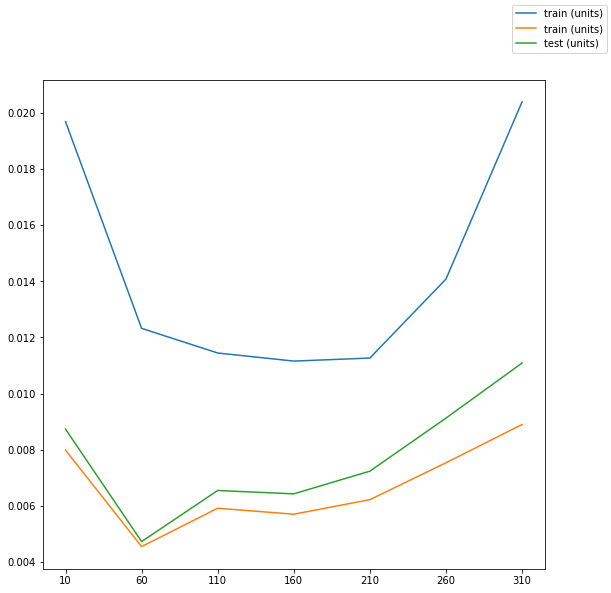

In [523]:
fig = plt.figure(figsize=(9,9))
label='units'

train_label = "train ({0})".format(label)
val_label = "val ({0})".format(label)
test_label = "test ({0})".format(label)

plt.plot(pd.DataFrame(tr).T[0],c='C0',label=train_label)
plt.plot(pd.DataFrame(v).T[0],c='C1',label=train_label)
plt.plot(pd.DataFrame(te).T[0],c='C2',label=test_label)

fig.legend()
#fig.set_xlabel("units")

#ax_val.set_ylabel("Validation MSE")
#ax_test.set_ylabel("Test MSE")



In [ ]:
def plot_learning(history,label,c,ax_loss,ax_acc):
  train_label = "train ({0})".format(label)
  val_label   = "validation ({0})".format(label)
  if 'loss' in history.history:
    ax_loss.plot(history.history['loss'],c=c,label=train_label)
  if 'val_loss' in history.history:
    ax_loss.plot(history.history['val_loss'],'--',c=c,label=val_label)
  if 'mean_squared_error' in history.history:
    ax_acc.plot(history.history['mean_squared_error'],c=c,label=train_label)
  if 'val_mean_squared_error' in history.history:
    ax_acc.plot(history.history['val_mean_squared_error'],'--',c=c,label=val_label)

  for ax in [ax_loss,ax_acc]:
    ax.legend()
    ax.grid('on')
    ax.set_xlabel("epoch")
  ax_loss.set_ylabel("Loss")
  ax_acc.set_ylabel("Accuracy")

In [471]:
pd.DataFrame(v).T[0]

10     0.007639
60     0.004576
110    0.004998
160    0.006076
210    0.005911
260    0.008356
310    0.008412
Name: 0, dtype: float64

## dropout rate

In [420]:
MAX_EPOCHS=10
t={}
v={}
dropout_rates_grid=np.arange(0.1,1,0.1)
for i in dropout_rates_grid: 
    lstm_model_test = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(200, return_sequences=True),
        tf.keras.layers.Dropout(i, seed=0),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)
    ])

    history = compile_and_fit(lstm_model_test, custom_window)

    IPython.display.clear_output()
    tr[str(i)] = lstm_model_test.evaluate(custom_window.val)
    v[str(i)] = lstm_model_test.evaluate(custom_window.val)
    te[str(i)] = lstm_model_test.evaluate(custom_window.test, verbose=0)

Epoch 1/10
220/220 [==============================] - 7s 24ms/step - loss: 0.0859 - mean_squared_error: 0.0859 - val_loss: 0.0266 - val_mean_squared_error: 0.0266
Epoch 2/10
220/220 [==============================] - 5s 25ms/step - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 3/10
 43/220 [====>.........................] - ETA: 3s - loss: 0.0100 - mean_squared_error: 0.0100

KeyboardInterrupt: 

# From Results to investment strategy

In this section, I used 
- historical data: a window of 30 minutes 
- goal: to predict the price in five minutes

In [129]:
train_predictions=lstm_model.predict(custom_window_lstm.train)
val_predictions=lstm_model.predict(custom_window_lstm.val)
test_predictions=lstm_model.predict(custom_window_lstm.test)

## Train

In [134]:
train_predictions.shape

(7030, 1)

In [131]:
train_df.shape

(7049, 4)

In [132]:
i=100
m=1440-100+i-1
n=1440+i-1
print(train_df.index[n:].shape)
print(train_predictions[:,m,0].shape)

(5510,)


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [133]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=train_df.index,
        y=train_df.mid_price*train_std['mid_price']+train_mean['mid_price']
    )
)

fig.add_trace(
    go.Scatter(
        x=train_df.index[n:],
        y=train_predictions[:,m,0]*train_std['mid_price']+train_mean['mid_price']
    )
)



fig.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

## Val

In [666]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=val_df.index,
        y=val_df.mid_price*train_std['mid_price']+train_mean['mid_price']
    )
)    

fig.add_trace(
    go.Scatter(
        x=val_df.index[34:],
        y=val_predictions[:,29,0]*train_std['mid_price']+train_mean['mid_price']
    )
)

fig.show()

## Test

In [669]:
fig = go.Figure()
    
fig.add_trace(
    go.Scatter(
        x=test_df.index,
        y=test_df.mid_price*train_std['mid_price']+train_mean['mid_price']
    )
)

fig.add_trace(
    go.Scatter(
        x=test_df.index[34:],
        y=test_predictions[:,29,0]*train_std['mid_price']+train_mean['mid_price']
    )
)

fig.show()

## Backtest Strategy

In [ ]:
def expected_gain
for i in range(29, )